# Purpose: Starting from Google Drive import to saving a .nii file to google drive

All of these steps from: https://developers.google.com/drive/api/v3/quickstart/python?source=post_page---------------------------

*Step 1: Importing Necessary Packages*

In [50]:
import os
from apiclient import discovery
from httplib2 import Http
import oauth2client
from oauth2client import file, client, tools
import pandas as pd
import nrrd
import nibabel as nib
import io
from googleapiclient.http import MediaIoBaseDownload

import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt

#Importing files from my packages
import ifmodels.register as register
import ifmodels.gdaccess as gdaccess
import ifmodels.preprocess as preprocess

*Step 2: User inputs*

In [51]:
folder_id = "'1GDUl93_NWjLS9qAVIdA1UukD3UqItFvo'" #Copy the file id into the inner set of single quotation marks
atlas_file_name = 'atlas_segmentation.nrrd' #Type in what your atlas file is named + the file type

*Step 3: Getting Google Drive Access*

In [52]:
import pydrive
from pydrive.auth import GoogleAuth as gauth
from pydrive.drive import GoogleDrive

from pydrive.auth import GoogleAuth

gauth = GoogleAuth()
gauth.LocalWebserverAuth() # Creates local webserver and auto handles authentication.

drive = GoogleDrive(gauth) # Create GoogleDrive instance with authenticated GoogleAuth instance

# Auto-iterate through all files in the root folder.



Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?client_id=311511771285-g66b7tm0525pnntbr67mv9t6qjud4bgk.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=offline&response_type=code

Authentication successful.




*Step 4: Get list of file names and file ids from specified google folder*

In [53]:
string = folder_id + ' in parents and trashed=false'

In [54]:
file_list = drive.ListFile({'q': string}).GetList()
names = []
ids = []
for file1 in file_list:
    names.append(file1['title'])
    ids.append(file1['id'])

*Step 5: Showing the list of file names and ids*

In [55]:
file_names = pd.DataFrame(list(zip(names, ids)), columns = ['names','ids'])
file_names

,names,ids
0,atlas_segmentation.nrrd,1Pj_D6bo-zdiJ9JoTq8-ViusRUCbz3h64
1,distances.xlsx,1gJXjESKZ5AVxKHp4Lf-3WVJHmGQ72ihr
2,slide66_slice3.tif,1A2Z0H0NsceFH7YrweRwWh84g07KgCeuR
3,slide67_slice2.tif,1pk4aB4JDTyYAC2924WZdSJT3wZ_dpe1b
4,slide66_slice2.tif,1QUC74m7A2kgVP2FPOVIXKGQY_C0BljZ9
5,slide66_slice1.tif,1kpQ-DRPLV4iC3HY8BGxklXCtp3BgTlkX
6,slide65_slice3.tif,1uESvcrpkbztEwQbMR0Y0xp25VpfOU5cf
7,slide65_slice2.tif,1cDBPRtVgq_Lf_gFF4dWKNdJbJCmXSaD7
8,slide65_slice1.tif,1oKN8sGQ4Yl7yKoCigyDR8qWlgIbs4ae_
9,slide64_slide3.tif,1TespqYjQSAqMF9uUVpR02MJi3qnCJlqq


*Step 6: Saving specific file_id and specifying a new file_name*

*Step x: Read in the Atlas Slice Locations*

In [14]:
distances_file = file_names.loc[file_names['names'] == 'distances.xlsx']
distances_file = distances_file.reset_index()

In [16]:
gdistances = drive.CreateFile({'id': distances_file['ids'][0]})
gdistances.GetContentFile(distances_file['names'][0])

In [17]:
corr_atlas = pd.read_excel(distances_file['names'][0])

*Step x: Cleaning the file_names database of the distances.xlsx data*

In [33]:
file_names = file_names[file_names.names!= 'distances.xlsx']

*Step x: Read in the universal atlas*

In [21]:
atlas_file = file_names.loc[file_names['names'] == atlas_file_name]

In [22]:
atlas_file = atlas_file.reset_index()

In [23]:
gatlas= drive.CreateFile({'id': atlas_file['ids'][0]})
gatlas.GetContentFile(atlas_file['names'][0])

In [24]:
F_im_nii = register.nrrd_to_nii(atlas_file_name)

In [28]:
file_names = file_names[file_names.names!= atlas_file_name]

In [29]:
k = 0

In [30]:
Registered_stack = np.zeros((9, 4280, 3200))

*My code from before that works for downloading and registering stuff but is giving me blank output*

In [34]:
for row in file_names.itertuples():
    file_id = row.ids
    new_file_name = row.names
    file6 = drive.CreateFile({'id': file_id})
    file6.GetContentFile(new_file_name)
    #gdaccess.download(new_file_name, file_id)
    
    im = register.im_read(new_file_name)
    binary = register.mim_edge_detector(im)
    binary = register.image_cleaning(binary)
    coor_df = register.find_points(binary)

    slice = corr_atlas.loc[corr_atlas['Slidetag'] == new_file_name[:-4]].values.tolist()[0]
    slice_number = slice[1]
    sagittal, coronal, horizontal = register.atlas_slice(F_im_nii, slice_number)
    resized = preprocess.resize(coronal, 20)
    resized = register.mim_edge_detector(resized)
    fim_coor_df = register.find_points(resized)
    
    df = pd.concat([coor_df, fim_coor_df], axis = 1)
    ainv = register.reg_coefficients(df, 1, 3, 5)
    #ainv = register.reg_coefficients(df, 1, 2, 3)
    registered_im = register.registration(im, ainv)
    Registered_stack[k] = registered_im
    os.remove(new_file_name)
    k = k + 1
    print(k, new_file_name)

1 slide66_slice3.tif
2 slide67_slice2.tif
3 slide66_slice2.tif
4 slide66_slice1.tif
5 slide65_slice3.tif
6 slide65_slice2.tif
7 slide65_slice1.tif


IndexError: list index out of range

In [35]:
full_brain = nib.Nifti2Image(Registered_stack, affine=np.eye(4))

In [36]:
full_brain.get_data_dtype() == np.dtype(np.int16)

False

In [37]:
full_brain.header.get_xyzt_units()

('unknown', 'unknown')

In [38]:
nib.save(full_brain, os.path.join('/Users/HawleyHelm/Desktop/image-registration/Dawley-p14','brain.nii.gz'))

FileNotFoundError: [Errno 2] No such file or directory: '/Users/HawleyHelm/Desktop/image-registration/Dawley-p14/brain.nii.gz'

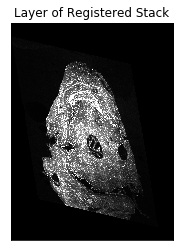

In [45]:
plt.imshow(Registered_stack[4], cmap = 'gray')
plt.title('Layer of Registered Stack')
plt.xticks([])
plt.yticks([])

plt.show()

*2D Visualization*

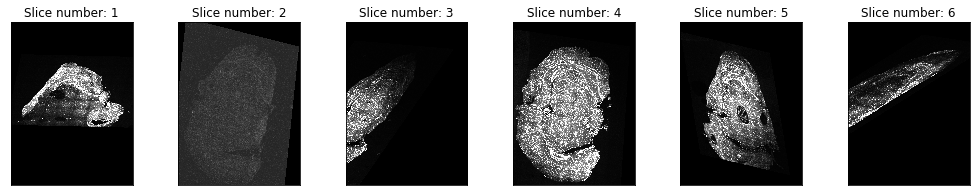

In [46]:
fig, ax = plt.subplots(1,6, figsize=[18,3])

n=0
slice=1
for _ in range(6):
    ax[n].imshow(Registered_stack[_], 'gray')
    ax[n].set_xticks([])
    ax[n].set_yticks([])
    ax[n].set_title('Slice number: {}'.format(slice), color='black')
    n += 1
    slice += 1
    
fig.subplots_adjust(wspace=0, hspace=0)
plt.show()

# Below this line is very developmental work

*Working with matplotlib 3D*

In [ ]:
from mpl_toolkits import mplot3d

In [ ]:
fig = plt.figure()
ax = plt.axes(projection = '3d')

In [ ]:
Registered_stack.shape

In [ ]:
Registered_stack[0].shape

In [ ]:
Registered_stack[0][1]

In [ ]:
#Data for three deminsional stuff
ax = plt.axes(projection = '3d')

# create a 21 x 21 vertex mesh
xx, yy = np.meshgrid(np.linspace(0,1,21), np.linspace(0,1,21))

# create vertices for a rotated mesh (3D rotation matrix)
X =  xx 
Y =  yy
Z =  10*np.ones(X.shape)

data = Registered_stack[3]

ax.plot_surface(X, Y, Z, rstride=1, cstride=1, facecolors=plt.cm.BrBG(data), shade=False)

In [ ]:
from mayavi import mlab
mlab.init_notebook()

In [ ]:
volume = mlab.pipeline.volume(mlab.pipeline.scalar_field(Registered_stack), vmin=0, vmax=0.8)

mlab.draw()
mlab.savefig('output.png')

In [ ]:
mlab.figure()
mlab.contour3d(Registered_stack, contours=[])
mlab.outline(color=(0,0,0))